\begin{center} SEIS734-02 \end{center}

\section[Section Title]{Algorithms\\}


To facilitate the effort of creating regression models for predicting the number of clicks we implemented the following algorithms.


1. Basic Regression Trees
2. Random Forest
3. Least Absolute Shrinkage and Selection Operator (LASSO)


## Basic Regression Trees


Our first regression model to implement was the Basic Regression Tree because they are easy to understand. Because of how they are constructed they are able to handle many types of predictors without a need for pre-processing. 


Our initial assumption that the training and test datasets would contain the same set of categorical variable values was wrong. Some of the categorical variables in our dataset was too many. As a result the model generated by the training dataset could not be used to predict clicks on a test dataset which had new categorical variables. To resolve this issue we opted to remove the categorical variables that had too many values.


We also used the trees to perform feature selection. Through this process we were able to identify the most important predictors in our dataset. Using these results were were able to get an understanding of our data and possibly simplify our models by removing some predictors.


## Random Forests


The structure of the basic regression tree can change drastically with slight changes in the data. As a result they are not very stable models. Their predictive performance for regression is also not optimal. This is because non-linear relationships between the predictors and response variables cannot be defined in a rectangular subspace.


The Basic Regression trees suffer from selection bias. The predictors with with a high number of distinct values will be favored over those with less distinct values.


Our dataset contained some categorical variables with extremely high distinct values when compared to the size of the dataset. As a result It was susceptible to selection bias. Because of this we decided to remove the categorical variables with high granularity.


Random Forest, just like any other ensemble model, provides some advantages over models that are not. This is because they reduce the variance of the prediction through the aggregation process. Additionally, Random Forest reduces tree correlation which can happen in bagged models.


## LASSO

Because of the low ratio of clicks in our dataset, we thought LASSO would yield better models because of regularization. The tree models showed that out of a total of 17 variables there were only 3 important variables in building the models. Because of this we wanted to use an algorithm that allows parameter estimates to be biased. This would remove some variables that are correlated through feature selection. Lasso can shrink some of the parameter estimates to 0 through penalizing. 

# Tool Selection

## GraphLab

In the previous **Project Plan** assignment we used `graphlab` to create training and test data files. We chose graphlab for data pre-processing because it uses out of core data structures. This allows the application to load large files without running out of memory

## R

`R` has a rich library of predictive modeling algorithms which are well documented. It is also an easy to use language with good documentation.

## AWS

We decided to use `AWS` because our data files were too big to load on our personal computers. We launched `EC2` with **R** and **160GB** of RAM.


# Data Preparation
Using our application from the project plan we generated the following files

1. clickTrainX contains the predictors for our training data
2. clickTrainY contains the solution for our training data
3. clickTestX contains the predictors for our test data
4. clickTestY contains the solution for our test data

Our dataset contains 13 predictors. `'impressions' 'display_url' 'ad_id' 'advertiser_id' 'depth' 'position' 'query_id' 'keyword_id' 'title_id' 'description_id' 'user_id' 'gender' 'age'`. Using this predictors we are trying to predict the number of clicks.

## Required R packages

The following are the R packages are used in the application

In [2]:
library (plyr)
library(rpart)
library(caret)
library(corrplot)
library(e1071)
library(hydroGOF)
library(randomForest)
library(elasticnet)
library(data.table)

Loading required package: lattice
Loading required package: ggplot2
Loading required package: zoo

Attaching package: ‘zoo’

The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric

randomForest 4.6-12
Type rfNews() to see new features/changes/bug fixes.

Attaching package: ‘randomForest’

The following object is masked from ‘package:ggplot2’:

    margin

Loading required package: lars
Loaded lars 1.2



## Load Data

In [4]:
setwd('/home/davis/seis734/group/ctr-dataprep/sample/')

## train
clickTrainX <- fread('clickTrainX.csv',sep = ",", header = T)
clickTrainY_ <- fread('clickTrainY.csv',sep = ",", header = T)

## test
clickTestX <- fread('clickTestX.csv',sep = ",",header = T)
clickTestY_ <- fread('clickTestY.csv',sep = ",", header = T)

numeric_cols <- names(clickTrainX) %in%  c("impressions","depth"
                                           ,"position")

modelResults <- clickTestY_
names(modelResults) <- c("clicks")
modelResults$impressions <- clickTestX$impressions


By default the `read.csv(...)` function loaded all our predictors as numeric. However, some of these predictors are simply IDs that we need to convert to `factors`.

In order to fit the data into our model, the `train` function in the `caret` library expects the `predictors` and the `solution` to be in one dataframe. We will create a new dataframe called `clickTrainData`

In [3]:
# Replace missing values with 0

clickTrainX[is.na(clickTrainX)] <- 0
clickTestX[is.na(clickTestX)] <- 0

# create factors
clickTrainX[!numeric_cols] <- lapply(clickTrainX[!numeric_cols]
                                     , factor)
clickTestX[!numeric_cols] <- lapply(clickTestX[!numeric_cols]
                                    , factor)

# convert Y to a vector
clickTrainY <- as.integer(unlist(clickTrainY_
                                 , recursive = TRUE
                                 , use.names = FALSE))
clickTestY <- as.integer(unlist(clickTestY_
                                , recursive = TRUE
                                , use.names = FALSE))

# add the solution y to the clickTrainData dataframe
clickTrainData <- clickTrainX
clickTrainData$y <- clickTrainY

# list the columns in the new dataframe
cat("column names \n",names(clickTrainData))

set.seed(1011)
idx <- createFolds(clickTrainY, returnTrain = TRUE)
ctrl <- trainControl(method = "cv", index = idx)

column names 
 impressions display_url ad_id advertiser_id depth position query_id keyword_id title_id description_id user_id gender age y

### High level data analysis

We use the `str(...)` function to view the structure of the data

In [4]:
str(clickTrainX)

'data.frame':	99999 obs. of  13 variables:
 $ impressions   : int  1 1 1 1 1 1 1 1 1 1 ...
 $ display_url   : Factor w/ 6352 levels "1234866103747040",..: 1487 1668 3350 4775 1127 3530 1447 192 3340 1668 ...
 $ ad_id         : Factor w/ 21135 levels "1000515","1000806",..: 6225 19019 19285 2916 13280 17771 4944 14367 18011 19020 ...
 $ advertiser_id : Factor w/ 5452 levels "81","82","87",..: 28 5029 4745 2430 3994 4779 3018 4150 4841 5029 ...
 $ depth         : int  3 2 3 3 1 2 2 2 2 2 ...
 $ position      : int  3 2 3 1 1 1 2 1 2 2 ...
 $ query_id      : Factor w/ 62724 levels "0","1","2","3",..: 1366 32379 39870 1366 39870 40292 53102 7860 40292 38993 ...
 $ keyword_id    : Factor w/ 21597 levels "0","1","2","3",..: 4378 316 13577 2020 14561 17771 1437 10532 17771 3477 ...
 $ title_id      : Factor w/ 29437 levels "0","1","2","3",..: 5226 12635 23575 1153 19828 21985 6679 17540 25581 20798 ...
 $ description_id: Factor w/ 23687 levels "0","1","2","3",..: 567 11763 10184 1370 17426 19

### Categorical variables

An analysis of the output above indicates that some categorical variabes have too many distinct values to create a sparse matrix. Since we did not have enough information to create dummy variables for the categorical variables, we opted to remove them from the modeling process.

> At this point we also noticed that depth and position predictors could be converted to categorial variables

In [5]:
clickTrainX[,5:6] <- lapply(clickTrainX[,5:6], factor)
clickTestX[,5:6] <- lapply(clickTestX[,5:6], factor)

tooManyLevels <- names(clickTrainX) %in%  
                  c("display_url","ad_id","advertiser_id"
                  ,"query_id","keyword_id","title_id"
                   ,"description_id","user_id")
clickTrainXAdjusted <- clickTrainX[!tooManyLevels]
clickTestXAdjusted <- clickTestX[!tooManyLevels]
str(clickTrainXAdjusted)

'data.frame':	99999 obs. of  5 variables:
 $ impressions: int  1 1 1 1 1 1 1 1 1 1 ...
 $ depth      : Factor w/ 3 levels "1","2","3": 3 2 3 3 1 2 2 2 2 2 ...
 $ position   : Factor w/ 3 levels "1","2","3": 3 2 3 1 1 1 2 1 2 2 ...
 $ gender     : Factor w/ 3 levels "0","1","2": 2 2 2 2 2 2 2 2 2 2 ...
 $ age        : Factor w/ 7 levels "0","1","2","3",..: 4 4 4 4 4 4 4 4 4 4 ...


### One-Hot Encoding

In order to make use of the categorical variables for our regression models we needed to perform a one-hot encoding

In [6]:
clickTrainXEncoding <- data.frame(clickTrainXAdjusted$impressions)
clickTrainXEncoding <- cbind(clickTrainXEncoding
                             , data.frame(model.matrix(
                                 ~clickTrainXAdjusted$depth-1)))
clickTrainXEncoding <- cbind(clickTrainXEncoding
                             , data.frame(model.matrix(
                                 ~clickTrainXAdjusted$position-1)))
clickTrainXEncoding <- cbind(clickTrainXEncoding
                             , data.frame(model.matrix(
                                 ~clickTrainXAdjusted$gender-1)))
clickTrainXEncoding <- cbind(clickTrainXEncoding
                             , data.frame(model.matrix(
                                 ~clickTrainXAdjusted$age-1)))

#Test 
clickTestXEncoding <- data.frame(clickTrainXAdjusted$impressions)
clickTestXEncoding <- cbind(clickTestXEncoding
                            , data.frame(model.matrix(
                                ~clickTrainXAdjusted$depth-1)))
clickTestXEncoding <- cbind(clickTestXEncoding
                            , data.frame(model.matrix(
                                ~clickTrainXAdjusted$position-1)))
clickTestXEncoding <- cbind(clickTestXEncoding
                            , data.frame(model.matrix(
                                ~clickTrainXAdjusted$gender-1)))
clickTestXEncoding <- cbind(clickTestXEncoding
                            , data.frame(model.matrix(
                                ~clickTrainXAdjusted$age-1)))

# Rename columns
col_names <- c("impressions"
              ,"depth1"
              ,"depth2"
              ,"depth3"
              ,"position1"
              ,"position2"
              ,"position3"
              ,"gender0"
              ,"gender1"
              ,"gender2"
              ,"age0"
              ,"age1"
              ,"age2"
              ,"age3"
              ,"age4"
              ,"age5"
              ,"age6")

names(clickTrainXEncoding) <- col_names
names(clickTestXEncoding) <- col_names
str(clickTrainXEncoding)

'data.frame':	99999 obs. of  17 variables:
 $ impressions: int  1 1 1 1 1 1 1 1 1 1 ...
 $ depth1     : num  0 0 0 0 1 0 0 0 0 0 ...
 $ depth2     : num  0 1 0 0 0 1 1 1 1 1 ...
 $ depth3     : num  1 0 1 1 0 0 0 0 0 0 ...
 $ position1  : num  0 0 0 1 1 1 0 1 0 0 ...
 $ position2  : num  0 1 0 0 0 0 1 0 1 1 ...
 $ position3  : num  1 0 1 0 0 0 0 0 0 0 ...
 $ gender0    : num  0 0 0 0 0 0 0 0 0 0 ...
 $ gender1    : num  1 1 1 1 1 1 1 1 1 1 ...
 $ gender2    : num  0 0 0 0 0 0 0 0 0 0 ...
 $ age0       : num  0 0 0 0 0 0 0 0 0 0 ...
 $ age1       : num  0 0 0 0 0 0 0 0 0 0 ...
 $ age2       : num  0 0 0 0 0 0 0 0 0 0 ...
 $ age3       : num  1 1 1 1 1 1 1 1 1 1 ...
 $ age4       : num  0 0 0 0 0 0 0 0 0 0 ...
 $ age5       : num  0 0 0 0 0 0 0 0 0 0 ...
 $ age6       : num  0 0 0 0 0 0 0 0 0 0 ...


**One-Hot Encoding** resulted in 17 predictor variables

# Basic Regression Tree Model

Our first model is a single Regression tree. Becauase of the simplicity of this model we expect the model to have sub-optimal predictive performance. Additionally with this type of tree we have a finite number of possible predicted outcomes which is determined by the number of terminal nodes. As a result we are not able to capture observations outside the training data set.

To test the quality of the model we use `RMSE`. We expect this tree to have the highest `RMSE` value because of it's simplicity.

In this model we use the `rpart` method of the caret library with a `tuneLegth = 30` using cross-validation. Our plot should contain 30 points that show how the `RMSE` changes with a change in the complexity parameter. The complexity parameter penalizes the error rate using the size of the tree. The goal is to find the the smallest tree with the lowest penalized rate.

$$SSE_{c_{p}} = SSE + c_{p} ∗ (Num Terminal Nodes)$$

In [7]:
start.time <- Sys.time()

# Tune the model
set.seed(1011)
cartTune <- train(x = clickTrainXEncoding, y = clickTrainY,
                  method = "rpart",
                  tuneLength = 30,
                  trControl = ctrl)

time.taken <- Sys.time() - start.time

cat("Duration ", time.taken, " seconds")

Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”

Duration  26.81058  seconds

## Model Evaluation

The output below shows RMSE and $R^2$ for the model generated. It also shows the complexity parameter used to build the smallest tree with the least RMSE

In [8]:
cartTune

CART 

99999 samples
   17 predictors

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 89999, 89999, 89999, 89999, 89999, 89999, ... 
Resampling results across tuning parameters:

  cp            RMSE       Rsquared  
  0.0001879300  0.2863961  0.15641464
  0.0002232318  0.2863959  0.15632967
  0.0002267204  0.2863837  0.15638502
  0.0002288656  0.2863821  0.15639116
  0.0002297421  0.2863821  0.15639116
  0.0002576505  0.2863976  0.15624805
  0.0002636898  0.2861763  0.15717834
  0.0002679865  0.2861735  0.15708589
  0.0002779490  0.2861539  0.15719278
  0.0003140244  0.2860959  0.15728904
  0.0003215824  0.2860543  0.15739215
  0.0003273014  0.2859715  0.15778499
  0.0004363129  0.2857644  0.15908273
  0.0005788966  0.2854956  0.16065802
  0.0006094530  0.2854833  0.16073558
  0.0007835899  0.2852592  0.16197453
  0.0008628999  0.2851955  0.16213778
  0.0009027613  0.2853063  0.16156790
  0.0009085728  0.2853231  0.16151261
  0.0010094374  0.2850365 

We can visualize the change in RMSE with different complexity parameters using the `plot` function

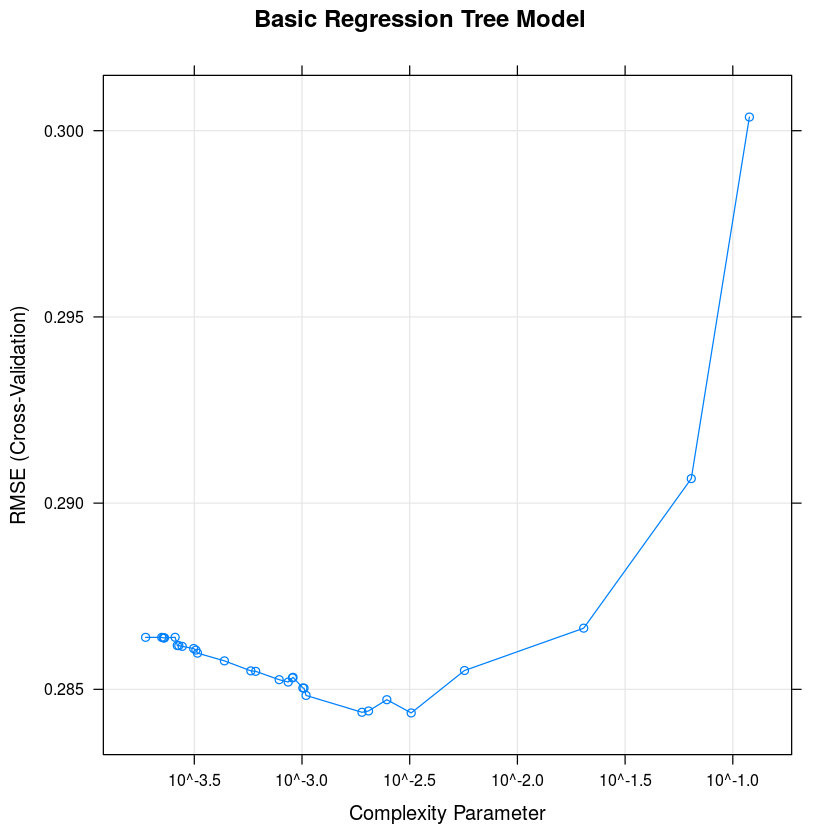

In [9]:
plot(cartTune, scales = list(x = list(log = 10))
     ,main="Basic Regression Tree Model")

>*The plot shows the change in RMSE as the complexity parameter changes*

We can determine the most important predictors by using the `varImp` function

In [10]:
cartImp <- varImp(cartTune, scale = FALSE, competes = FALSE)
cartImp

rpart variable importance

            Overall
impressions 0.49202
depth1      0.04701
position1   0.02265
gender2     0.00000
age1        0.00000
position3   0.00000
depth2      0.00000
age3        0.00000
age2        0.00000
gender1     0.00000
age4        0.00000
position2   0.00000
gender0     0.00000
age0        0.00000
age6        0.00000
depth3      0.00000
age5        0.00000

The results indicate that the `impressions` `depth` and `position` are the best predictors for the number of clicks. This seems correct from our understanding of the data. It makes sense that `impresions` is the best predictors because the more impressions an Ad has the more chances it has to get clicks. `depth` and `position` relate to the positioning of an Ad on a web page. Ads at the top of the page are more likely to be clicked than those at the bottom of the page. The models indicate that Ads at position 1 and depth 1 are more likely to generate clicks.

### Correlation

We check for correlations using the `cor` function. The model can be simplified by removing highly correlated variables.

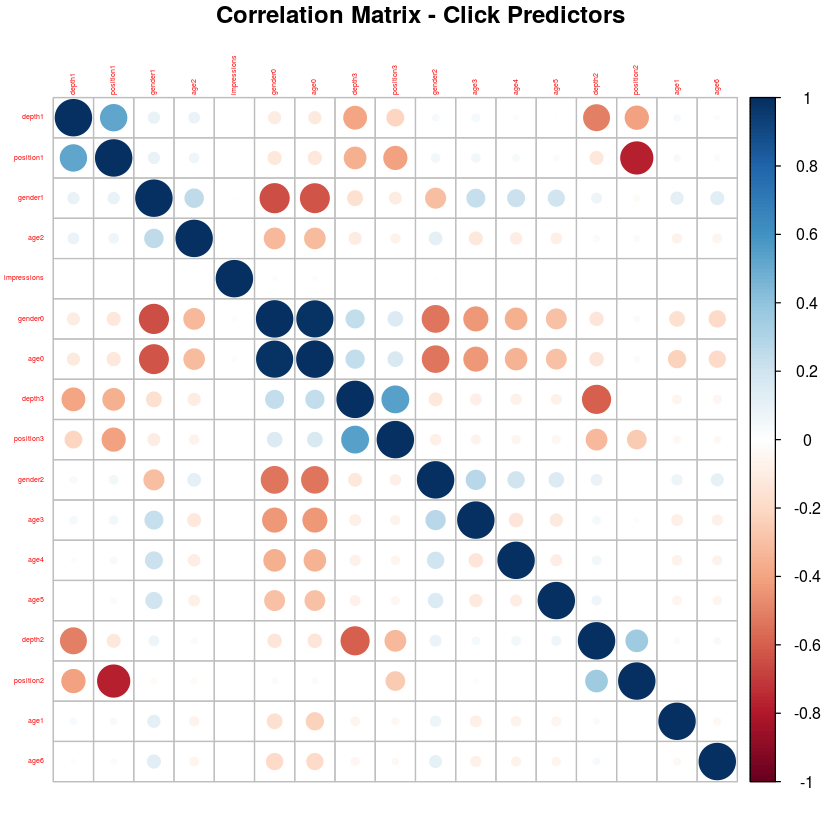

In [11]:
clickCorr <- cor(clickTrainXEncoding)
corrplot(clickCorr, order = "hclust", tl.cex = .35
         , main ="\nCorrelation Matrix - Click Predictors")

It appears that some of our predictors might have a high correlation. We set the cut-off threshold to 0.9 to remove the highly correlated predictors.

In [12]:
highCorr <- findCorrelation(clickCorr, cutoff = 0.9)
head(highCorr)
filteredClickTrainXEncoding <- clickTrainXEncoding[,-highCorr]
filteredClickTestXEncoding <- clickTestXEncoding[,-highCorr]
str(filteredClickTrainXEncoding)

cat('The following predictors will be removed\n'
    ,names(clickTestXEncoding)[highCorr])

[1] 11

'data.frame':	99999 obs. of  16 variables:
 $ impressions: int  1 1 1 1 1 1 1 1 1 1 ...
 $ depth1     : num  0 0 0 0 1 0 0 0 0 0 ...
 $ depth2     : num  0 1 0 0 0 1 1 1 1 1 ...
 $ depth3     : num  1 0 1 1 0 0 0 0 0 0 ...
 $ position1  : num  0 0 0 1 1 1 0 1 0 0 ...
 $ position2  : num  0 1 0 0 0 0 1 0 1 1 ...
 $ position3  : num  1 0 1 0 0 0 0 0 0 0 ...
 $ gender0    : num  0 0 0 0 0 0 0 0 0 0 ...
 $ gender1    : num  1 1 1 1 1 1 1 1 1 1 ...
 $ gender2    : num  0 0 0 0 0 0 0 0 0 0 ...
 $ age1       : num  0 0 0 0 0 0 0 0 0 0 ...
 $ age2       : num  0 0 0 0 0 0 0 0 0 0 ...
 $ age3       : num  1 1 1 1 1 1 1 1 1 1 ...
 $ age4       : num  0 0 0 0 0 0 0 0 0 0 ...
 $ age5       : num  0 0 0 0 0 0 0 0 0 0 ...
 $ age6       : num  0 0 0 0 0 0 0 0 0 0 ...
The following predictors will be removed
 age0

> **The age0 predictor was found to be correlated with another variable**

### Skewness

We also need to check for skewness in the data. Skewness in the data might introduce some bias in the generated model. To do this we used the `skewness` function in the `e1071` library to calculate the skewness statistic.

272.6358 1.162509 0.2562567 0.7974486 -0.1900717 0.7037577

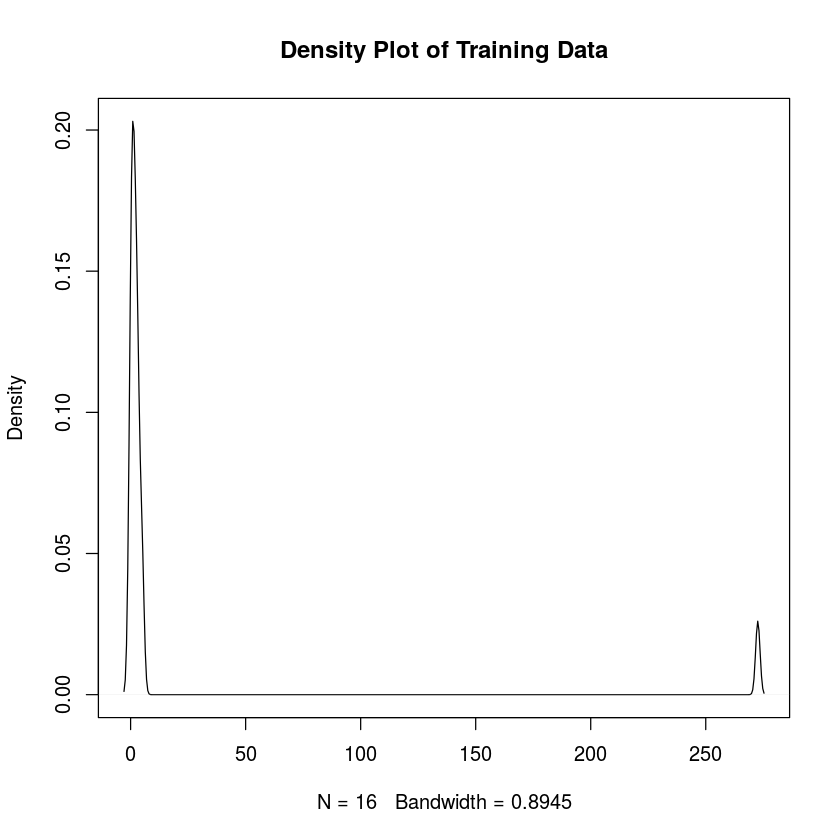

In [13]:
skewValues <- apply(filteredClickTrainXEncoding,2, skewness)
plot(density(skewValues),main="Density Plot of Training Data")
cat(head(skewValues))

### Transformed Basic Regression Tree Model

It can be observed that the ratio of the skewness statistic compared to the other predictors is extremely high. We will use the BoxCox transformation from the caret package to adjust our data. We also use PCA to try and extract relationships between our predictors

Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”

Duration  43.46951  seconds

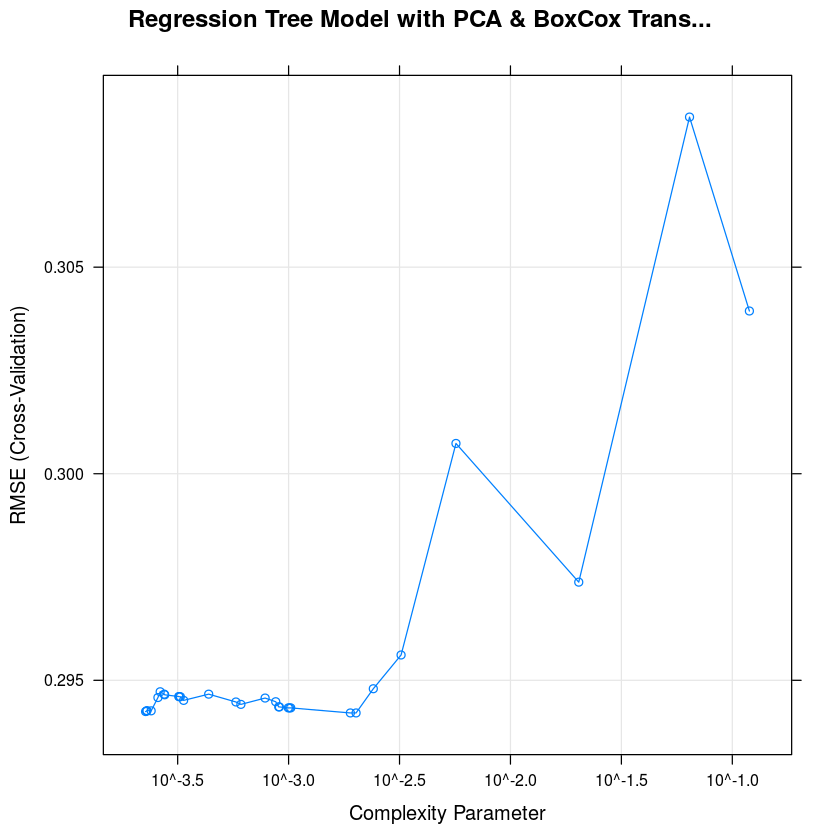

In [14]:
start.time <- Sys.time()
# Box Cox Transformation
set.seed(1011)
cartTuneTrans <- train(x = filteredClickTrainXEncoding, y = clickTrainY,
                       method = "rpart",
                       tuneLength = 30,
                       trControl = ctrl,
                       preProc = c("pca","BoxCox"))

time.taken <- Sys.time() - start.time
cat("Duration ", time.taken, " seconds")

plot(cartTuneTrans, scales = list(x = list(log = 10))
    ,main = "Regression Tree Model with PCA & BoxCox Trans...")

### Basic Regression Tree Models RMSE

We can now use the two models to predict clicks on our test data. We will also use the `rmse` function in the `hydroGOF` library to calculate RMSE

In [23]:
cartTuneResults <- data.frame(obs = clickTestY,
                          CART = predict(cartTune
                                         , clickTestXEncoding))
cartTuneTransResults <- data.frame(obs = clickTestY,
                          CART = predict(cartTuneTrans
                                         , filteredClickTestXEncoding))

cat("Basic Reg Tree RMSE", rmse(cartTuneResults$obs
                          , cartTuneResults$CART),"\n")
cat("Transformed Regression Tree RMSE"
    , rmse(cartTuneTransResults$obs
    , cartTuneTransResults$CART),"\n")

modelResults$cartTune <- predict(cartTune
                                         , clickTestXEncoding)
modelResults$cartTuneTrans <- predict(cartTuneTrans
                                         , filteredClickTestXEncoding)


Basic Reg Tree RMSE 0.6084502 
Transformed Regression Tree RMSE 0.6042053 


As expected it can be observed that our second model with data transformations to remove skewness and highly correlated predictors has a lower RMSE

## Bagged Trees

Bagging is a technique that uses bootstrapping in conjunction with any regression model to construct an ensemble. Bagging reduces the variance of the predictions through the aggregation process.

### Random Forests

Random Forests add randomness into the learning process. The randomness reduces the correlation between trees. To build a Ramdom Forest model we used the `randomforest` function in the `randomforest` package.

In [16]:
# rfGrid <- data.frame(
#     mtry = floor(seq(10
#                      , ncol(filteredClickTrainXEncoding)
#                      , length = 10)))
# rfData <- filteredClickTrainXEncoding
# rfData$y <- clickTrainY

# start.time <- Sys.time()
# set.seed(1011)
# randomForest <- train(y ~. 
#                       , data = rfData
#                       ,method = "rf"
#                       ,tuneGrid = rfGrid
# #                       ,ntree = 13
#                       ,importance = TRUE
#                       ,trControl = ctrl)

# time.taken <- Sys.time() - start.time
# randomForest
# plot(randomForest)
# randomForestImp <- varImp(randomForest, scale = FALSE)
# randomForestImp
# cat("Duration ", time.taken, " seconds")

We can now use the newly created random forest model to predict the number of clicks in our test data and calculate the RMSE. Our expectation is that the Ramdom Forest Model will perform better than the two Basic Regression Tree Model because of bagging which reduces the variance of the predictions.

In [17]:
# randomForestResults <- data.frame(
#     obs = clickTestY,
#     CART = predict(randomForest, filteredClickTestXEncoding))
# modelResults$RANDOM_FOREST <- predict(randomForest, filteredClickTestXEncoding)
# cat("Random Forest RMSE", rmse(randomForestResults$obs
#                                , randomForestResults$CART),"\n")


## TODO TODO TODO TOD)
The random forest performed better? explain

# Linear Regression Model

Linear models are ideal when the predictor and response variable have a linear relationship. If the relationships between the predictors variables and response variable in our data are linear then this model would be ideal.

## LASSO

Lasso performas variable selection and regulalization to enhance prediction accuracy. We used the enet function of the elasticnet package to generate this model.

Elasticnet 

99999 samples
   16 predictors

Pre-processing: principal component signal extraction (16),
 Box-Cox transformation (1), centered (16), scaled (16) 
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 89999, 89999, 89999, 89999, 89999, 89999, ... 
Resampling results across tuning parameters:

  lambda  fraction    RMSE       Rsquared   
  0.00    0.05000000  0.3036655  0.007170455
  0.00    0.08275862  0.3035092  0.007170455
  0.00    0.11551724  0.3033709  0.007170455
  0.00    0.14827586  0.3032521  0.007254551
  0.00    0.18103448  0.3031432  0.007989690
  0.00    0.21379310  0.3030406  0.008584901
  0.00    0.24655172  0.3029470  0.009005612
  0.00    0.27931034  0.3028628  0.009313737
  0.00    0.31206897  0.3027870  0.009677646
  0.00    0.34482759  0.3027163  0.010038608
  0.00    0.37758621  0.3026516  0.010324771
  0.00    0.41034483  0.3025929  0.010550450
  0.00    0.44310345  0.3025402  0.010727593
  0.00    0.47586207  0.3024943  0.010874885
  0.00

            Length Class      Mode     
call          4    -none-     call     
actions      12    -none-     list     
allset       11    -none-     numeric  
beta.pure   132    -none-     numeric  
vn           11    -none-     character
mu            1    -none-     numeric  
normx        11    -none-     numeric  
meanx        11    -none-     numeric  
lambda        1    -none-     numeric  
L1norm       12    -none-     numeric  
penalty      12    -none-     numeric  
df           12    -none-     numeric  
Cp           12    -none-     numeric  
sigma2        1    -none-     numeric  
xNames       11    -none-     character
problemType   1    -none-     character
tuneValue     2    data.frame list     
obsLevels     1    -none-     logical  

LASSO RMSE 0.5916538 
Duration  1.283547  seconds

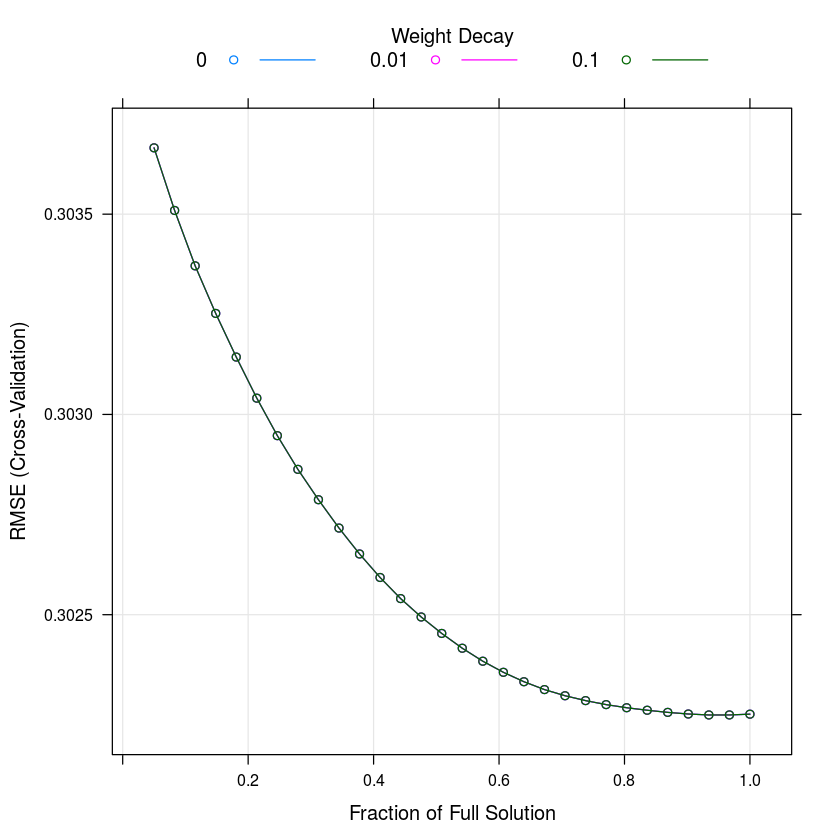

In [18]:
enetGrid <- expand.grid(lambda = c(0, 0.01, .1), 
                        fraction = seq(.05, 1, length = 30))

start.time <- Sys.time()
set.seed(1011)
lassoTune <- train(x = as.matrix(filteredClickTrainXEncoding), 
                  y = clickTrainY,
                  method = "enet",
                  tuneGrid = enetGrid,
                  trControl = ctrl,
                  preProc = c("pca","BoxCox"))

time.taken <- Sys.time() - start.time

lassoTune
summary(lassoTune)
plot(lassoTune)

lassoTuneResults <- data.frame(
    obs = clickTestY,
    LASSO = predict(lassoTune, filteredClickTestXEncoding))

cat("LASSO RMSE", rmse(lassoTuneResults$obs, 
                       lassoTuneResults$LASSO),"\n")
modelResults$lasso <- predict(lassoTune, filteredClickTestXEncoding)
cat("Duration ", time.taken, " seconds")

LASSO had an `RMSE` 0.5916023 which is better than the best RMSE of the Single Regression Trees model and Random Forests. This indicates that the relationships between the predictor variables and the response variable are probably linear.

# Model Performance

## Parallel-coordinate plots

To visualize the performance profiles of the click prediction models used, we used `parallel-coordinate plots` for RMSE and $R^2$

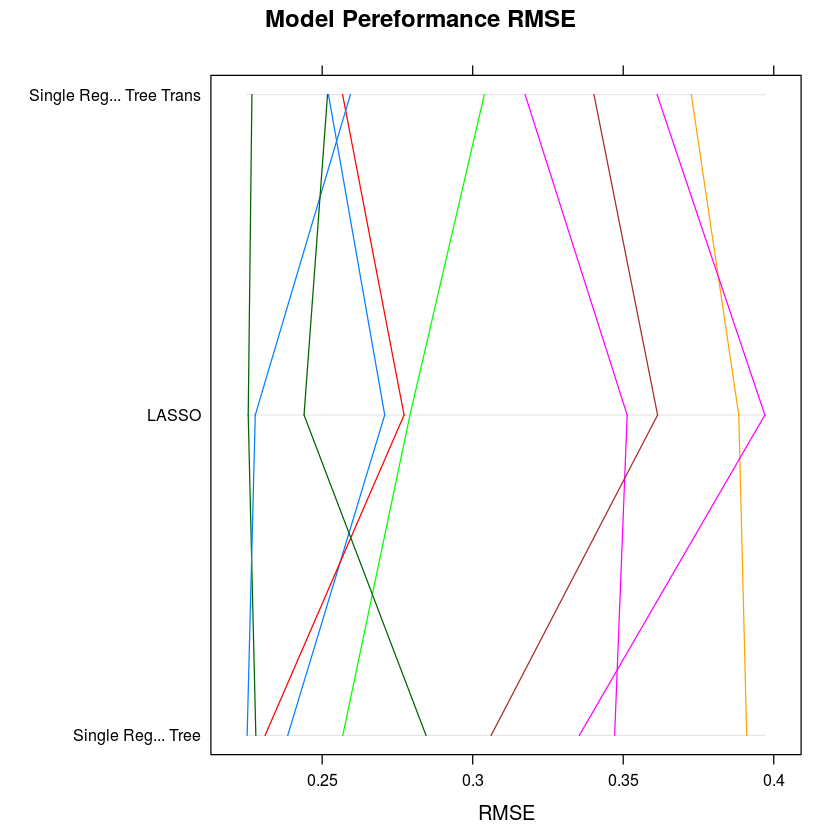

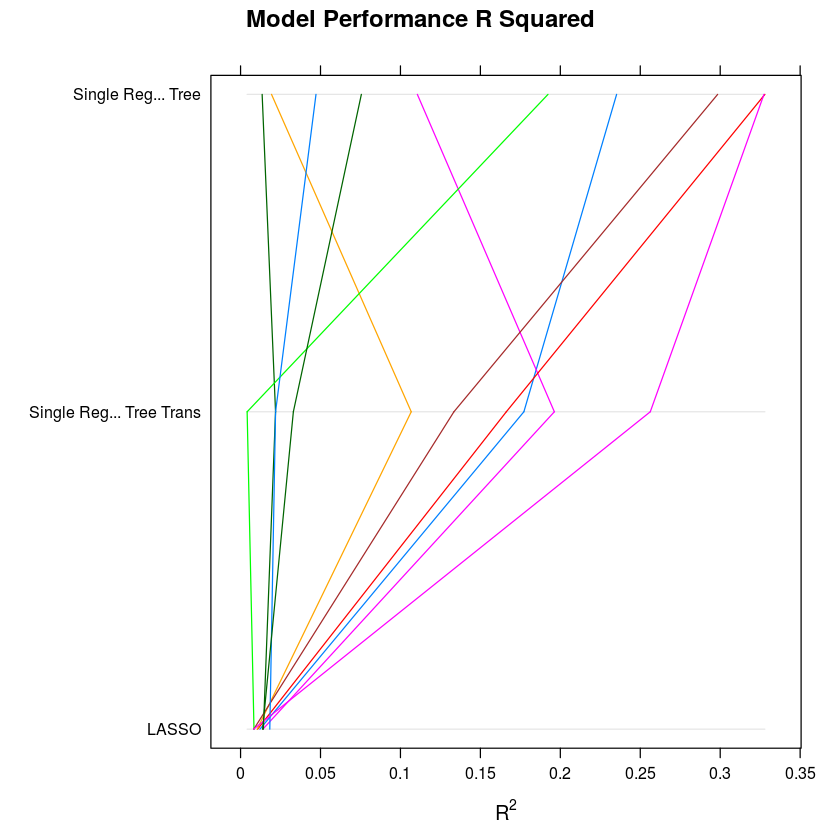

In [19]:
modelResamples <- resamples(list(
                     "Single Reg... Tree" = cartTune,
                     "Single Reg... Tree Trans" = cartTuneTrans,
#                      "Random Forest" = randomForest,
                     "LASSO" = lassoTune ))
parallelplot(modelResamples
             , main = "Model Pereformance RMSE")
parallelplot(modelResamples
             , metric = "Rsquared"
             , main="Model Performance R Squared")

From these diagrams we can tell that the top performing model was LASSO followed by Random forest. the single tree regression models did not perform well.

## Diagnostic plots

We also made use of diagnostic plots to test the predictive quality of each model on our test set.

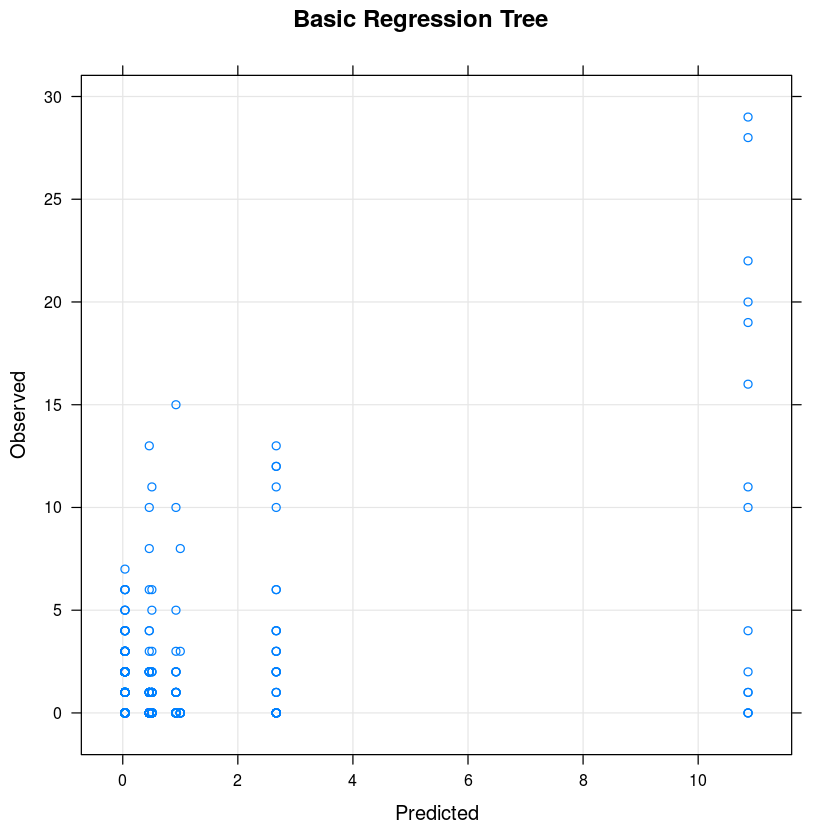

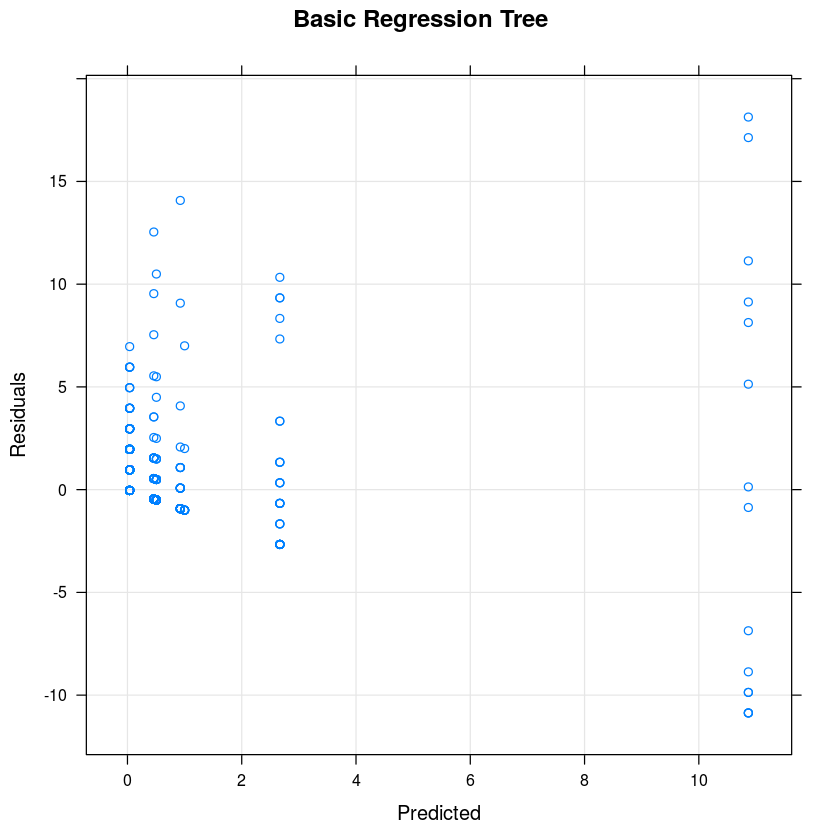

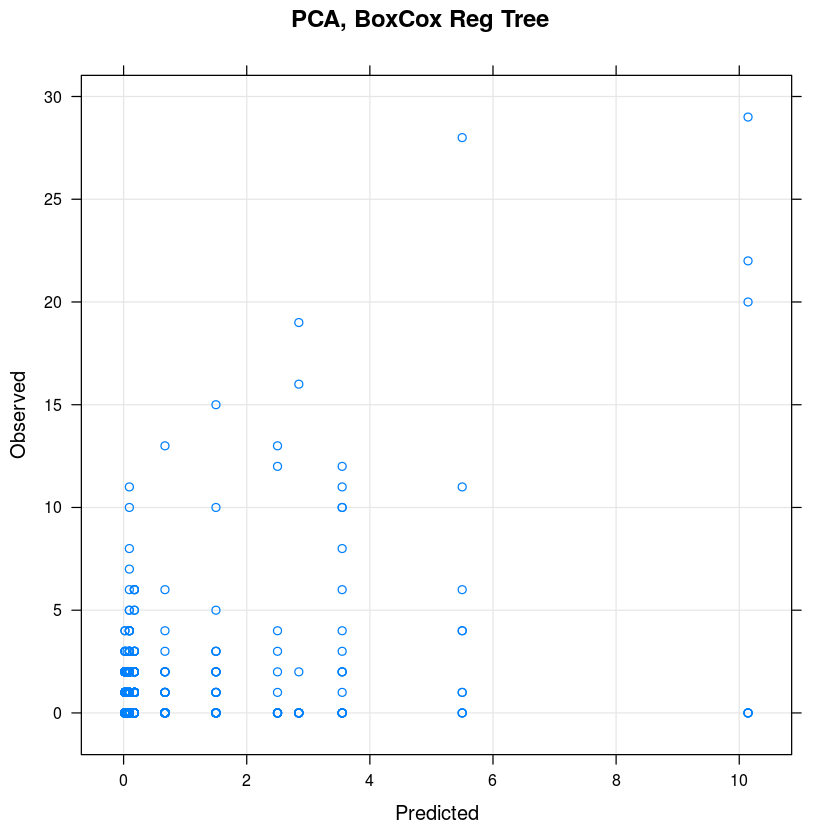

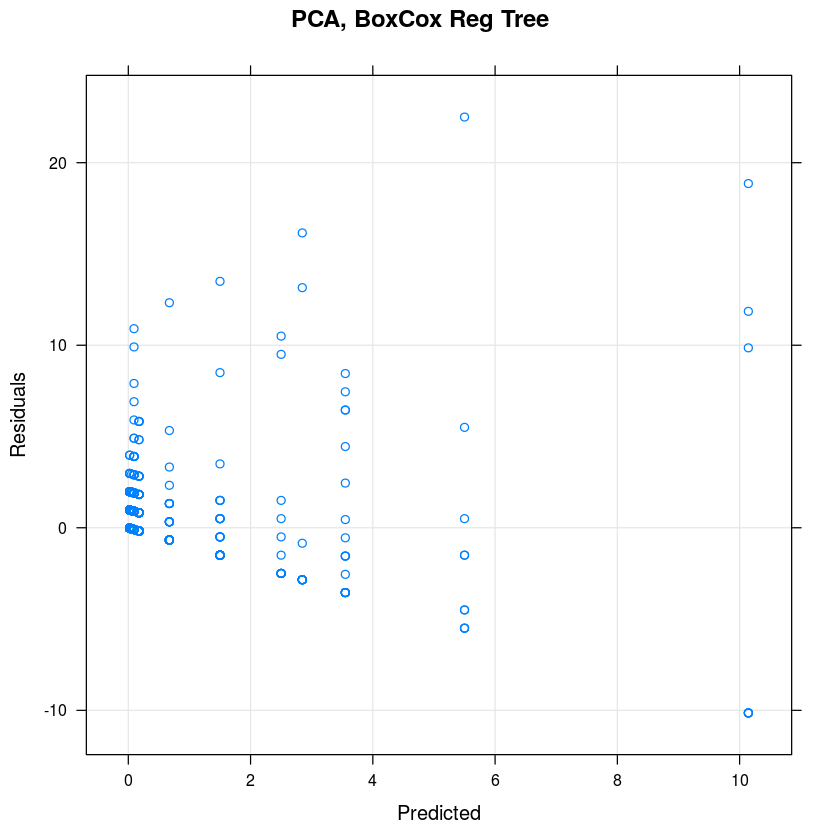

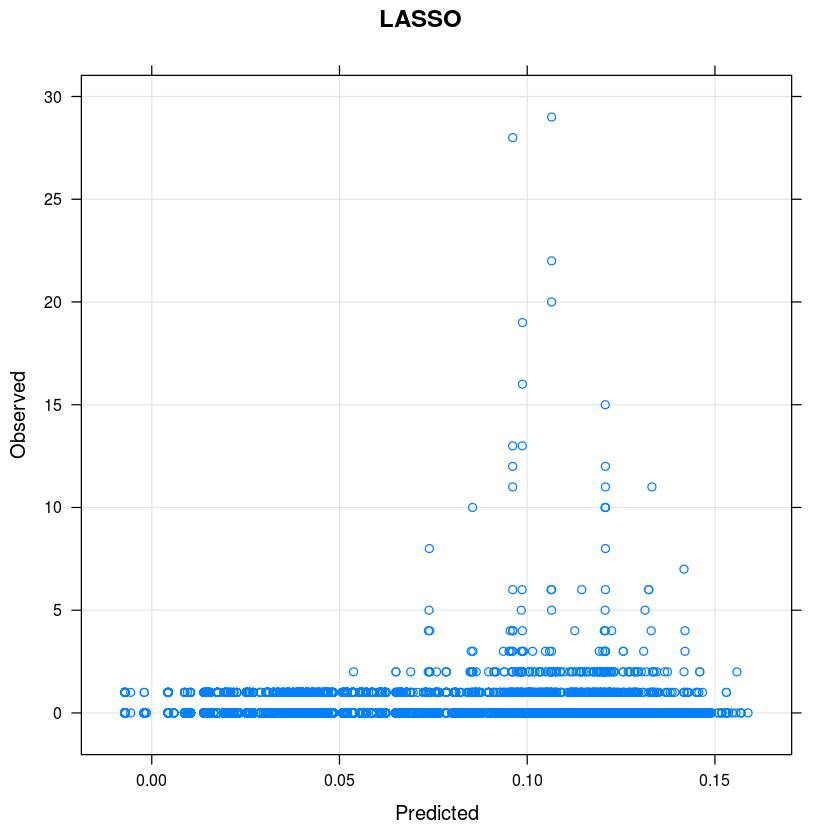

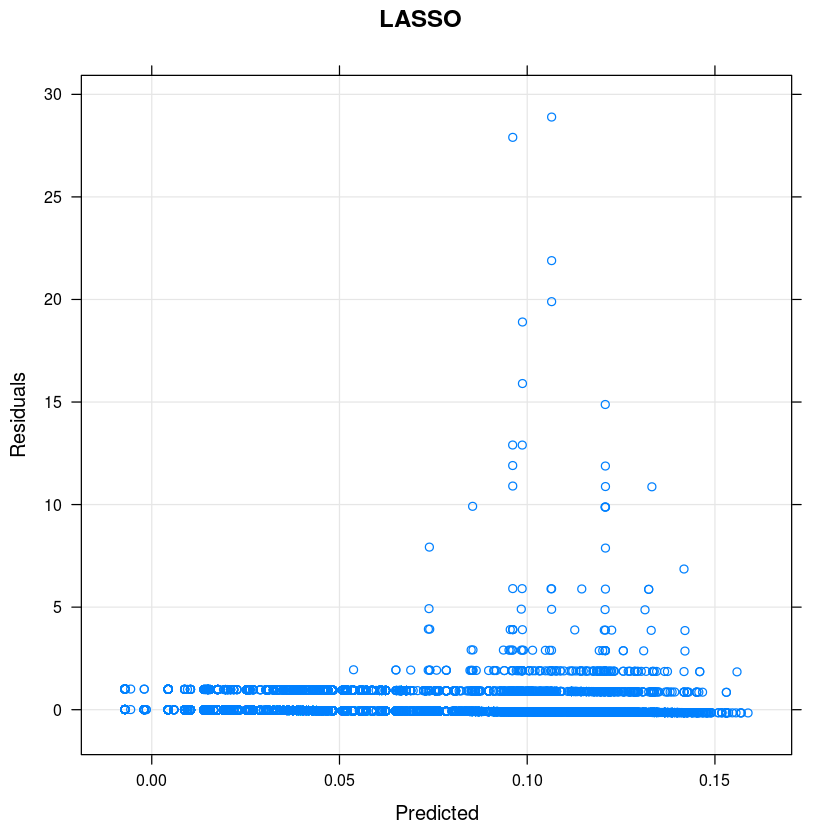

In [20]:
xyplot(clickTrainY ~ predict(cartTune),
      type = c("p", "g"),
      xlab = "Predicted", ylab = "Observed",
      main = "Basic Regression Tree")
xyplot(resid(cartTune) ~ predict(cartTune),
      type = c("p", "g"),
      xlab = "Predicted", ylab = "Residuals",
      main = "Basic Regression Tree")

# BoxCox, PCA
xyplot(clickTrainY ~ predict(cartTuneTrans),
      type = c("p", "g"),
      xlab = "Predicted", ylab = "Observed",
      main = "PCA, BoxCox Reg Tree")
xyplot(resid(cartTuneTrans) ~ predict(cartTuneTrans),
      type = c("p", "g"),
      xlab = "Predicted", ylab = "Residuals",
      main = "PCA, BoxCox Reg Tree")

# Random Forest
# xyplot(clickTrainY ~ predict(randomForest),
#       type = c("p", "g"),
#       xlab = "Predicted", ylab = "Observed",
#       main = "Random Forest")
# xyplot(resid(randomForest) ~ predict(randomForest),
#       type = c("p", "g"),
#       xlab = "Predicted", ylab = "Residuals",
#       main = "Random Forest")

# LASSO
xyplot(clickTrainY ~ predict(lassoTune),
      type = c("p", "g"),
      xlab = "Predicted", ylab = "Observed",
      main = "LASSO")
xyplot(resid(lassoTune) ~ predict(lassoTune),
      type = c("p", "g"),
      xlab = "Predicted", ylab = "Residuals",
      main = "LASSO")

# Summary

## How do we compare

Using the algorithm provided by KDD Cup to compute the AUC for this problem, our models had an AUC of **XXXXXXXXXXXXXTODO TODO TODO TODO TODO**. The winning group had a model with an `RMSE` of **0.80893**

## Calculate AUC

The following function was provided to calculate AUC

```python
    scoreClickAUC(num_clicks, num_impressions, predicted_ctr):
```

In [50]:
# Save model predictions to table
submission_file <- data.frame(
    ctr = modelResults$lasso/clickTestX$impressions)
fwrite(submission_file, "submission_file.csv", col.name=FALSE)

solution_file <- data.frame(clickTestY_)
solution_file$impressions <- clickTestX$impressions
names(solution_file) <- c("clicks", "impressions")
fwrite(solution_file, "solution_file.csv", col.name=FALSE)

